In [1]:
#paremeters to be inputted
#change the paremeters before running the program!!!
#if on jupyter, again change the parameters and then run this part!!!

#put star name
starName = 'HD 61827' #do put space between HD and number

#select molecule as follows -
# 2-Methylnaphthalene -> 1
# Acenaphthene -> 2
# Benzo[ghi]perylene -> 3
# Pentacene -> 4
# Perylene -> 5
# Phenanthrene -> 6
# Pyrene -> 7
# Phenalenyl -> 8
# Any other molecule -> 0 and input the molecule name (according to parameters file)
moleculeNo = 2

#put lower range of wavelengths to extract from edibles data
minWave = 3000

#put upper range of wavelengths to extract from edibles data
maxWave = 5500

#if you want to force edit cleaned up data file, change fEdit to 1, otherwise keep it to 0
fEdit1 = 0

#if you want to force edit final stacked data and image files, change fEdit to 1, otherwise keep it to 0
fEdit2 = 0

In [2]:
#getting molecule name from given molecule number above
#if on jupyter, just run this part

if moleculeNo == 1:
    molName = '2MethylNaphthalene'
elif moleculeNo == 2:
    molName = 'Acenaphthene'
elif moleculeNo == 3:
    molName = 'Benzoghiperylene'
elif moleculeNo == 4:
    molName = 'Pentacene'
elif moleculeNo == 5:
    molName = 'Perylene'
elif moleculeNo == 6:
    molName = 'Phenanthrene'
elif moleculeNo == 7:
    molName = 'Pyrene'
elif moleculeNo == 8:
    molName = 'Phenalenyl'
elif moleculeNo == 0:
    molName = input('Enter molecule file name (as in parameters file):\n')

In [3]:
#importing necessary libraries
#if on jupyter, just run this part

import numpy as np
import matplotlib.pyplot as plt
from edibles.utils.edibles_oracle import EdiblesOracle
from edibles.utils.edibles_spectrum import EdiblesSpectrum
from edibles.utils.ContinuumFitter import ContinuumFitter
from stackingFunctions import widthNormLinStacker
from lmfit.models import VoigtModel
import copy
from stackingFunctions import observationStacker
from peakBasedFunctions import voigtUniPeak
from edibles import PYTHONDIR
import os.path
import warnings
from astropy.modeling import models
from astropy import units as u
from specutils.spectra import Spectrum1D
from specutils.fitting import fit_generic_continuum

In [4]:
#loading relevant data files from edibles
#if on jupyter, just run this part

pythia = EdiblesOracle()
rawList = pythia.getFilteredObsList(object = [starName], MergedOnly = True, WaveMin = minWave, WaveMax = maxWave)
fnames = rawList.tolist()
obs = len(fnames)

E:\college\mitacs\ediblesDataDR4
***Common Objects***
['HD 61827']
**Filtered File List**
19447     /HD61827/RED_564/HD61827_w564_n7_20180325_L.fits
19452     /HD61827/RED_564/HD61827_w564_n1_20180324_L.fits
19529    /HD61827/BLUE_346/HD61827_w346_n7_20180325_B.fits
19578    /HD61827/BLUE_346/HD61827_w346_n1_20180324_B.fits
19631    /HD61827/BLUE_437/HD61827_w437_n6_20180317_B.fits
Name: Filename, dtype: object
5


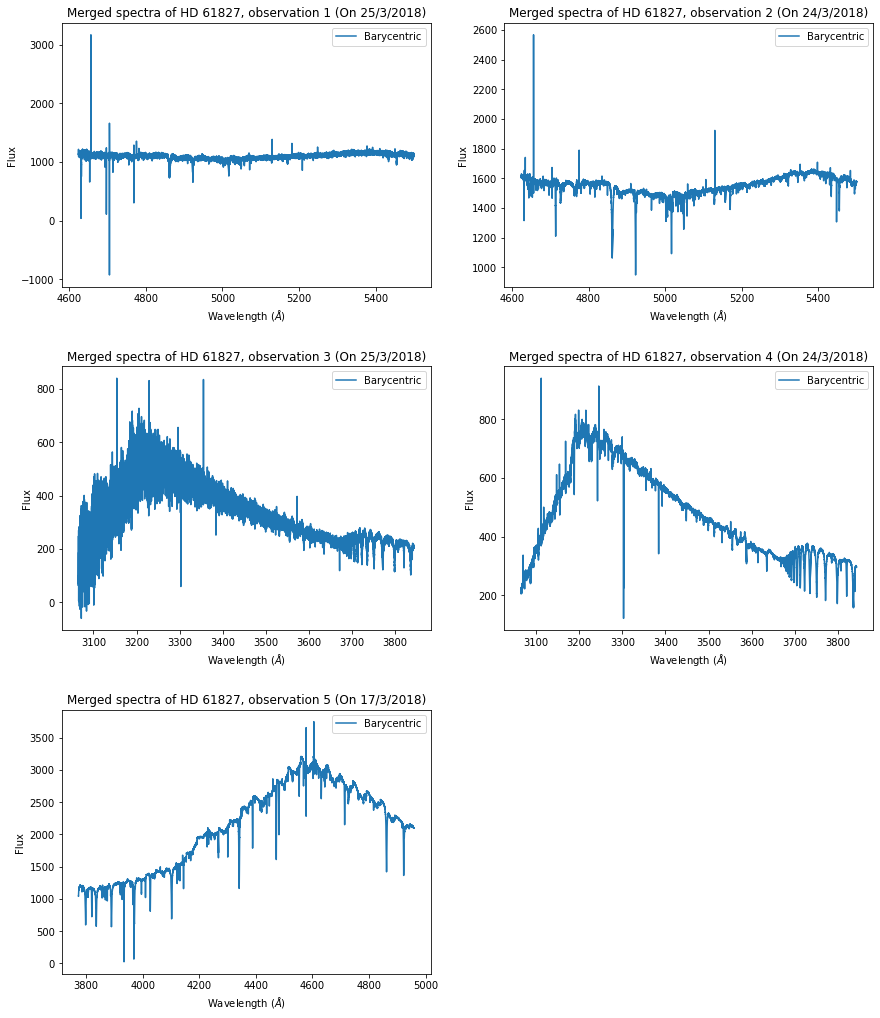

In [5]:
#extracting information from data files and plotting the graphs
#if on jupyter, just run this part

#structure of array of datasRaw array is as ->
#[array of info of first observation,
# array of info of second observation,
# array of info of third observation,.....]
#
#where structure of array of info of a observation is as ->
#[date of observation as a string, array of data of observation]
#
#where in the array of data of observation, first column is the wavelengths 
#and second column is the respective intensities

datasRaw = np.empty(shape = obs, dtype = object)

ffig1, faxs1 = plt.subplots(-(-obs//2), 2, figsize=(12,-5*(-obs//2)))
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

for it1, file in enumerate(fnames):
    sp = EdiblesSpectrum(file)
    #print('minWave is '+str(minWave))
    #print('raw_wave min is '+str(np.min(sp.raw_wave)))
    #print('maxWave is '+str(maxWave))
    #print('raw_wave max is '+str(np.max(sp.raw_wave)))
    
    leftEdge = 0
    rightEdge = 0
    
    if minWave <= np.min(sp.raw_wave):
        leftEdge = 1
        #print('Left edge detected')
    if maxWave >= np.max(sp.raw_wave):
        rightEdge = 1
        #print('Right edge detected')
    
    #sp.getSpectrum(xmin = max(minWave, np.min(sp.raw_wave))
    #               , xmax = min(maxWave, np.max(sp.raw_wave)))
    sp.getSpectrum(xmin = max(minWave, np.min(sp.raw_wave)+1)
                   , xmax = min(maxWave, np.max(sp.raw_wave)-1))
    #sp.getSpectrum(xmin = max(minWave, np.min(sp.raw_wave[sp.raw_wave != np.min(sp.raw_wave)])), 
    #               xmax = min(maxWave, np.max(sp.raw_wave[sp.raw_wave != np.max(sp.raw_wave)])))
    
    #infoArr first column  -> date (string)
    #        second column -> data
    infoArr = np.empty(shape = 2, dtype = object)
    infoArr[0] = str(sp.datetime.day) + '/' + str(sp.datetime.month) + '/' + str(sp.datetime.year)
    infoArr[1] = np.delete(np.array([sp.bary_wave, sp.bary_flux]).transpose(), 
                           np.logical_or(sp.bary_wave <= np.min(sp.bary_wave) + 40.0*leftEdge, 
                                         sp.bary_wave >= np.max(sp.bary_wave) - 40.0*rightEdge), 0)
    
    #if leftEdge:
    #    infoArr[1] = np.delete(infoArr[1], infoArr[1][:, 0] <= np.min(infoArr[1][:, 0]) + 40.0, 0)
    #    print('Left edge deletion happened')
        
    #if rightEdge:
    #    infoArr[1] = np.delete(infoArr[1], infoArr[1][:, 0] >= np.max(infoArr[1][:, 0]) - 40.0, 0)
    #    print('Right edge deletion happened')
    
    #print(infoArr[1])
    
    datasRaw[it1] = infoArr
    
    if(obs < 3):
        desax1 = faxs1[it1]
    else:
        desax1 = faxs1[it1//2, it1%2]
    
    #desax1.plot(sp.wave, sp.flux, label="Geocentric")
    desax1.plot(datasRaw[it1][1][:, 0], datasRaw[it1][1][:, 1], label="Barycentric")
    tit1 = 'Merged spectra of ' + starName + ', observation ' + str(it1+1) + ' (On ' + datasRaw[it1][0]+ ')'
    desax1.set_title(tit1)
    desax1.set(xlabel = r'Wavelength ($\AA$)', ylabel = 'Flux')
    desax1.legend()

if obs%2 != 0:
    ffig1.delaxes(faxs1[obs//2, 1])

plt.subplots_adjust(hspace=0.3, wspace=0.2)

In [16]:
#removing some bad observations
#put in the observations (array) which are bad and you want to remove them, and then run this part!!!
badObs = np.array([3])
#print(badObs-1)

#structure of array of datasBadRem array is as ->
#[array of info of first observation,
# array of info of second observation,
# array of info of third observation,.....]
#
#where structure of array of info of a observation is as ->
#[date of observation as a string, array of data of observation]
#
#where in the array of data of observation, first column is the wavelengths 
#and second column is the respective intensities

datasBadRem = copy.deepcopy(np.delete(datasRaw, badObs - 1))
obs = len(datasBadRem)

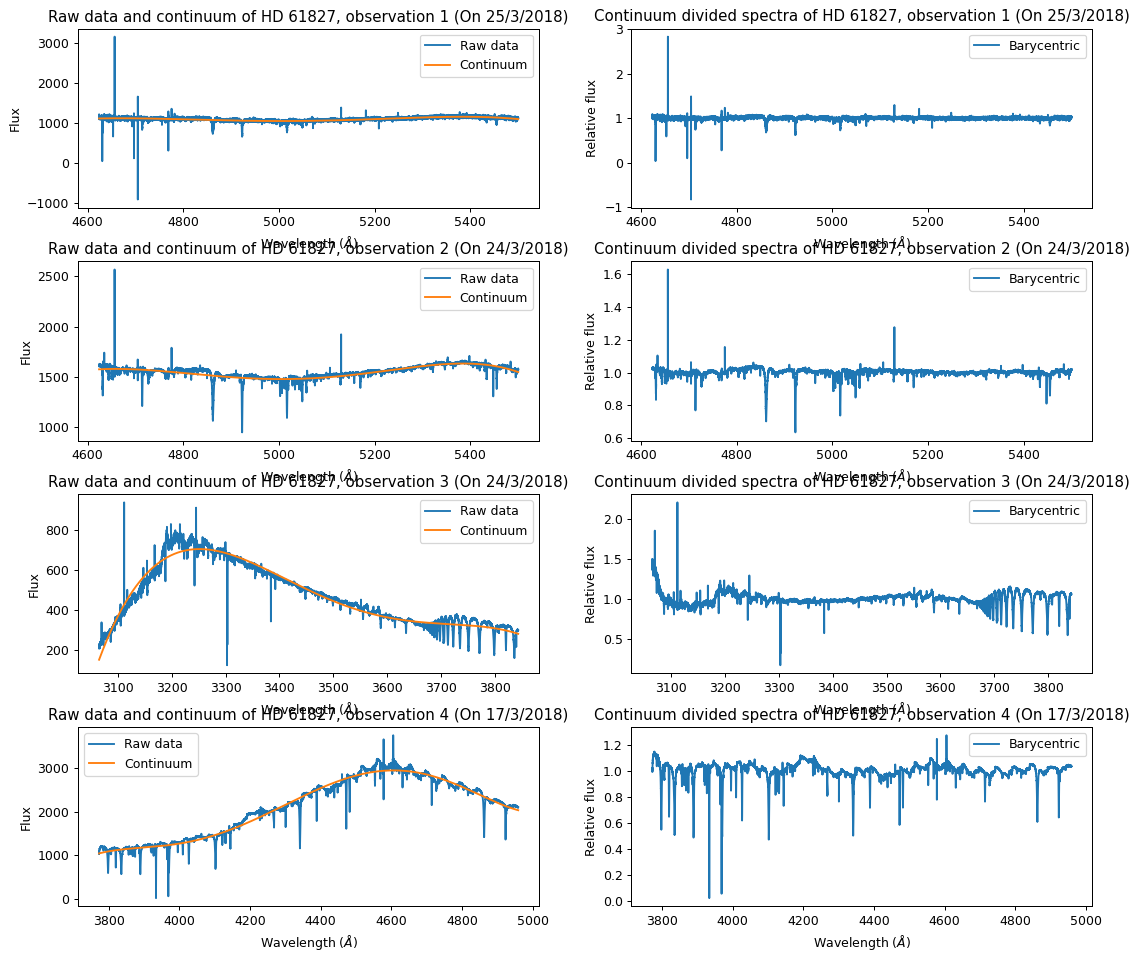

In [17]:
#removing the continuum from the spectrum
#if on jupyter, just run this part

#structure of array of datasContRem array (after continuum removal is done) is as ->
#[array of info of first observation,
# array of info of second observation,
# array of info of third observation,.....]
#
#where structure of array of info of a observation is as ->
#[date of observation as a string, array of data of observation]
#
#where in the array of data of observation (artifacts removed), first column is the wavelengths 
#and second column is the respective intensities (continuum removed)

datasContRem = copy.deepcopy(datasBadRem)

ffig2, faxs2 = plt.subplots(obs, 2, figsize=(12,5*obs))
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

for it2 in range(obs):
    #CF2 = ContinuumFitter(datasRaw[it2][1][:, 0], datasRaw[it2][1][:, 1])
    #CS1, contPoints1  = CF2.SplineManualAnchor()
    #datasContRem[it2][1][:, 1] = datasRaw[it2][1][:, 1]/CS1(datasRaw[it2][1][:, 0])
    
    x1 = copy.deepcopy(datasBadRem[it2][1][:, 0])
    y1 = copy.deepcopy(datasBadRem[it2][1][:, 1])

    spectrum1 = Spectrum1D(flux = y1*u.dimensionless_unscaled, spectral_axis = x1*u.angstrom)

    with warnings.catch_warnings():  # Ignore warnings
        warnings.simplefilter('ignore')
        g1_fit = fit_generic_continuum(spectrum1, model = models.Legendre1D(degree = 5))
    
    datasContRem[it2][1][:, 1] = y1/g1_fit(x1*u.angstrom)
    
    if(obs < 2):
        desax2i = faxs2[0]
        desax2ii = faxs2[1]
    else:
        desax2i = faxs2[it2, 0]
        desax2ii = faxs2[it2, 1]
    
    desax2i.plot(x1, y1, label = "Raw data")
    desax2i.plot(x1, g1_fit(x1*u.angstrom), label = "Continuum")
    tit2i = 'Raw data and continuum of ' + starName + ', observation ' + str(it2+1) + ' (On ' + datasContRem[it2][0] + ')'
    desax2i.set_title(tit2i)
    desax2i.set(xlabel = r'Wavelength ($\AA$)', ylabel = 'Flux')
    desax2i.legend()
    
    desax2ii.plot(x1, datasContRem[it2][1][:, 1], label = 'Barycentric')
    tit2ii = 'Continuum divided spectra of ' + starName + ', observation ' + str(it2+1) + ' (On ' + datasContRem[it2][0] + ')'
    desax2ii.set_title(tit2ii)
    desax2ii.set(xlabel = r'Wavelength ($\AA$)', ylabel = 'Relative flux')
    desax2ii.legend()

#if obs%2 != 0:
#    ffig2.delaxes(faxs2[obs//2, 1])

plt.subplots_adjust(hspace=0.3, wspace=0.2)

In [18]:
#helper function for accessing a section of data in given wavelength range (length 2 array)
#if on jupyter, just run this part

def dataInRange(data1, rangeArr1):
    return data1[np.logical_and(data1[:, 0] >= rangeArr1[0], data1[:, 0] <= rangeArr1[1]), :]

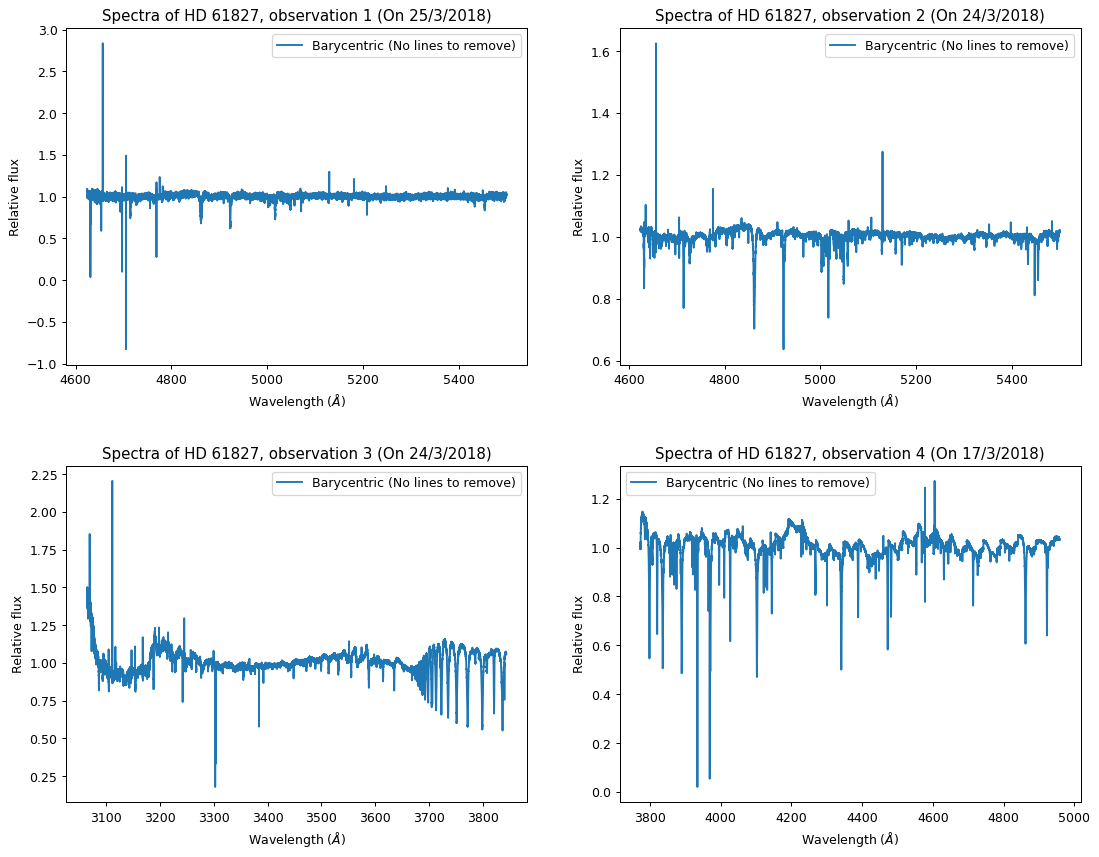

In [19]:
#removing the emission lines from the spectrum
#if on jupyter, just run this part

#structure of array of datasLineRem array (after stellar line removal is done) is as ->
#[array of info of first observation,
# array of info of second observation,
# array of info of third observation,.....]
#
#where structure of array of info of a observation is as ->
#[date of observation as a string, array of data of observation]
#
#where in the array of data of observation (artifacts removed), first column is the wavelengths 
#and second column is the respective intensities (continuum and emission lines removed)

datasEmRem = copy.deepcopy(datasContRem)

ffig5, faxs5 = plt.subplots(-(-obs//2), 2, figsize=(12,-5*(-obs//2)))
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

for it10 in range(obs):
    CF4 = ContinuumFitter(datasContRem[it10][1][:, 0], datasContRem[it10][1][:, 1])
    wvs2Full = CF4.SelectPoints(n=100, y_message = 'Select emission peak start and end points', nearest = False, vetoTimeout = True)
    
    if(obs < 3):
        desax5 = faxs5[it10]
    else:
        desax5 = faxs5[it10//2, it10%2]
    
    if(wvs2Full.shape[0] == 0):
        desax5.plot(datasEmRem[it10][1][:, 0], datasEmRem[it10][1][:, 1], label="Barycentric (No lines to remove)")
    
    else:
        wvs2 = wvs2Full[:, 0]
        wvs2y = wvs2Full[:, 1]
        peakRanges2 = np.reshape(wvs2, (int(wvs2.size/2), 2))
        peakRanges2y = np.reshape(wvs2y, (int(wvs2y.size/2), 2))
        for it11 in range(peakRanges2.shape[0]):
            #yForFit1 = 1 - datasContRem[it3][1][np.logical_and(datasContRem[it3][1][:, 0] >= peakRanges[it4, 0], datasContRem[it3][1][:, 0] <= peakRanges[it4, 1]), 1]
            #xForFit1 = datasContRem[it3][1][np.logical_and(datasContRem[it3][1][:, 0] >= peakRanges[it4, 0], datasContRem[it3][1][:, 0] <= peakRanges[it4, 1]), 0]
            #mod1 = VoigtModel()
            #params1 = mod1.guess(yForFit1, x = xForFit1)
            #res1 = mod1.fit(yForFit1, params1, x = xForFit1)
            #print('Doing peak ' + str(it11))
            dcir = dataInRange(datasContRem[it10][1], peakRanges2[it11])
            base1 = np.linspace(peakRanges2y[it11, 0], peakRanges2y[it11, 1], num = dcir.shape[0])
            res2 = voigtUniPeak(peakData = dcir, plot = 0, base = base1, retMod = True)
            datasEmRem[it10][1][np.logical_and(datasEmRem[it10][1][:, 0] >= peakRanges2[it11, 0], datasEmRem[it10][1][:, 0] <= peakRanges2[it11, 1]), 1] = dcir[:, 1]/(base1 - res2.best_fit)
        
        desax5.plot(datasContRem[it10][1][:, 0], datasContRem[it10][1][:, 1], label="Barycentric (Emission lines not removed)")
        desax5.plot(datasEmRem[it10][1][:, 0], datasEmRem[it10][1][:, 1], label="Barycentric (Emission lines removed)")
    
    tit5 = 'Spectra of ' + starName + ', observation ' + str(it10+1) + ' (On ' + datasEmRem[it10][0] + ')'
    desax5.set_title(tit5)
    desax5.set(xlabel = r'Wavelength ($\AA$)', ylabel = 'Relative flux')
    desax5.legend()

if obs%2 != 0:
    ffig5.delaxes(faxs5[obs//2, 1])

plt.subplots_adjust(hspace=0.3, wspace=0.2)

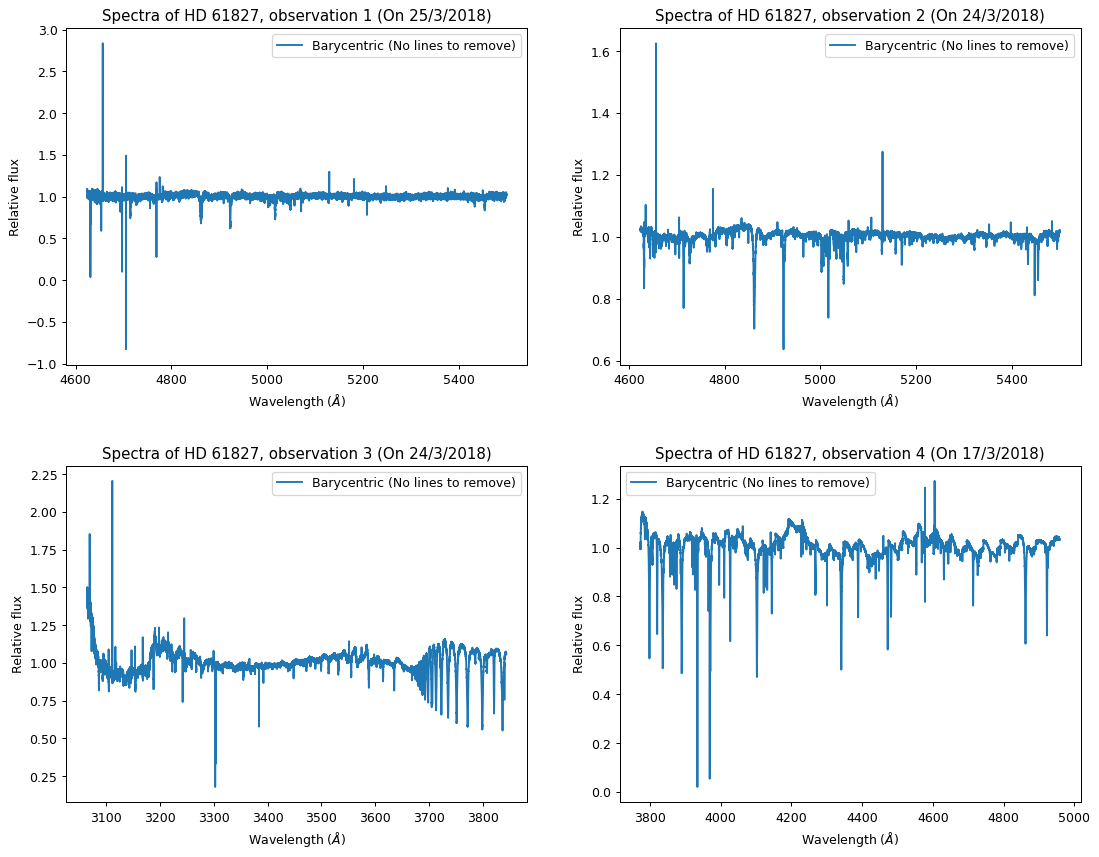

In [20]:
#removing the stellar lines from the spectrum
#if on jupyter, just run this part

#structure of array of datasLineRem array (after stellar line removal is done) is as ->
#[array of info of first observation,
# array of info of second observation,
# array of info of third observation,.....]
#
#where structure of array of info of a observation is as ->
#[date of observation as a string, array of data of observation]
#
#where in the array of data of observation (artifacts removed), first column is the wavelengths 
#and second column is the respective intensities (continuum and stellar line removed)

datasLineRem = copy.deepcopy(datasEmRem)

ffig3, faxs3 = plt.subplots(-(-obs//2), 2, figsize=(12,-5*(-obs//2)))
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

for it3 in range(obs):
    CF3 = ContinuumFitter(datasEmRem[it3][1][:, 0], datasEmRem[it3][1][:, 1])
    wvs1Full = CF3.SelectPoints(n=100, y_message = 'Select absorption peak start and end points', nearest = False, vetoTimeout = True)
    
    if(obs < 3):
        desax3 = faxs3[it3]
    else:
        desax3 = faxs3[it3//2, it3%2]
    
    if(wvs1Full.shape[0] == 0):
        desax3.plot(datasLineRem[it3][1][:, 0], datasLineRem[it3][1][:, 1], label="Barycentric (No lines to remove)")
    
    else:
        wvs1 = wvs1Full[:, 0]
        wvs1y = wvs1Full[:, 1]
        peakRanges = np.reshape(wvs1, (int(wvs1.size/2), 2))
        peakRangesy = np.reshape(wvs1y, (int(wvs1y.size/2), 2))
        for it4 in range(peakRanges.shape[0]):
            #yForFit1 = 1 - datasEmRem[it3][1][np.logical_and(datasEmRem[it3][1][:, 0] >= peakRanges[it4, 0], datasEmRem[it3][1][:, 0] <= peakRanges[it4, 1]), 1]
            #xForFit1 = datasEmRem[it3][1][np.logical_and(datasEmRem[it3][1][:, 0] >= peakRanges[it4, 0], datasEmRem[it3][1][:, 0] <= peakRanges[it4, 1]), 0]
            #mod1 = VoigtModel()
            #params1 = mod1.guess(yForFit1, x = xForFit1)
            #res1 = mod1.fit(yForFit1, params1, x = xForFit1)
            dcir1 = dataInRange(datasEmRem[it3][1], peakRanges[it4])
            base2 = np.linspace(peakRangesy[it4, 0], peakRangesy[it4, 1], num = dcir1.shape[0])
            res1 = voigtUniPeak(peakData1 = dcir1, plot = 0, base = base2, retMod = True)
            datasLineRem[it3][1][np.logical_and(datasLineRem[it3][1][:, 0] >= peakRanges[it4, 0], datasLineRem[it3][1][:, 0] <= peakRanges[it4, 1]), 1] = dcir1[:, 1]/(base2 - res1.best_fit)
        
        desax3.plot(datasEmRem[it3][1][:, 0], datasEmRem[it3][1][:, 1], label="Barycentric (Absorption lines not removed)")
        desax3.plot(datasLineRem[it3][1][:, 0], datasLineRem[it3][1][:, 1], label="Barycentric (Absorption lines removed)")
    
    
    tit3 = 'Spectra of ' + starName + ', observation ' + str(it3+1) + ' (On ' + datasLineRem[it3][0] + ')'
    desax3.set_title(tit3)
    desax3.set(xlabel = r'Wavelength ($\AA$)', ylabel = 'Relative flux')
    desax3.legend()

if obs%2 != 0:
    ffig3.delaxes(faxs3[obs//2, 1])

plt.subplots_adjust(hspace=0.3, wspace=0.2)

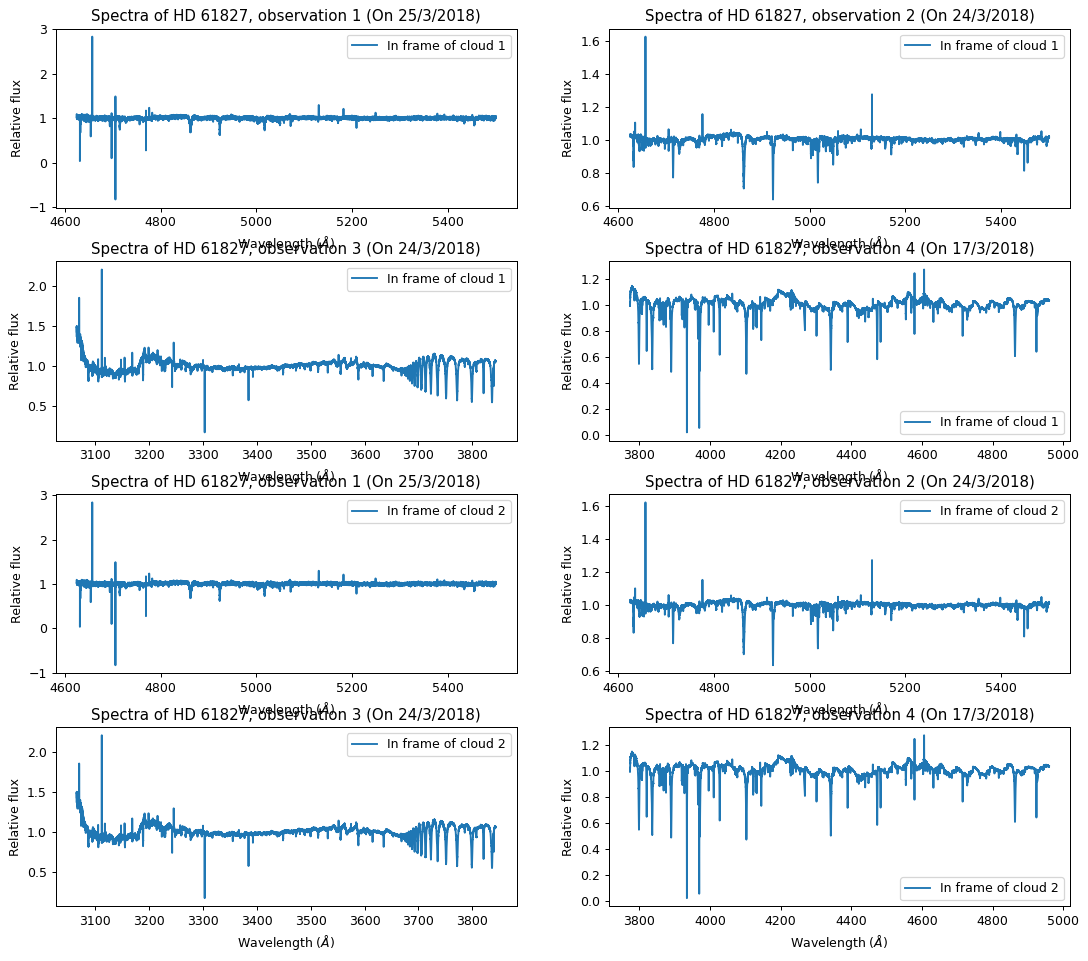

In [21]:
#shifting the spectrum to the clouds' frame
#if on jupyter, just run this part

#structure of datas array (after frame shifting is done) is as ->
#[array of all observations info in first cloud frame, 
# array of all observations info in second cloud frame, 
# array of all observations info in third cloud frame,.....]
#
#where structure of array of all observations info in a cloud's frame is as ->
#[array of info of first observation,
# array of info of second observation,
# array of info of third observation,.....]
#
#where structure of array of info of a observation is as ->
#[date of observation as a string, array of data of observation]
#
#where in the array of data of observation (artifacts removed), first column is the wavelengths (shifted in frame of cloud) 
#and second column is the respective intensities (continuum and stellar line removed)


with open(r'E:\college\mitacs\codes\cloudVels.txt') as f:
    for line in f:
        # Remove newline char
        line = line.replace('\n', '')

        # Split the line into a list by a comma
        line = line.split(',')
        
        if(line[0]) == starName.replace(' ', ''):
            vels = line[1].split(';')
            break

clouds = len(vels)
datas = np.empty(shape = clouds, dtype = object)
for it7 in range(clouds):
    datas[it7] = copy.deepcopy(datasLineRem)

ffig4, faxs4 = plt.subplots(-((-obs*clouds)//2), 2, figsize=(12,-7*((-obs*clouds)//2)))
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

for it6 in range(clouds):
    for it5 in range(obs):
        datas[it6][it5][1][:, 0] = datas[it6][it5][1][:, 0] * (1 + (float(vels[it6])/299792.458))
        
        if(obs*clouds < 3):
            desax4 = faxs4[it6*obs + it5]
        else:
            desax4 = faxs4[(it6*obs + it5)//2, (it6*obs + it5)%2]
    
        lab1 = 'In frame of cloud ' + str(it6+1)
        desax4.plot(datas[it6][it5][1][:, 0], datas[it6][it5][1][:, 1], label=lab1)
        tit4 = 'Spectra of ' + starName + ', observation ' + str(it5+1) + ' (On ' + datas[it6][it5][0] + ')'
        desax4.set_title(tit4)
        desax4.set(xlabel = r'Wavelength ($\AA$)', ylabel = 'Relative flux')
        desax4.legend()
        
if (obs*clouds)%2 != 0:
    ffig4.delaxes(faxs4[(obs*clouds)//2, 1])

plt.subplots_adjust(hspace=0.3, wspace=0.2)

In [22]:
#loading the parameters of the given molecule
#if on jupyter, just run this part

paramFile = 'C:\\Users\\hkhan\\edibles\edibles\\utils\\Harshit\\Lab Spectra Parameters\\' + molName + 'Params.txt'
molParam = np.loadtxt(paramFile)
#print(perylene)

No peaks in range
No peaks in range
No peaks in range
No peaks in range
No peaks in range
No peaks in range


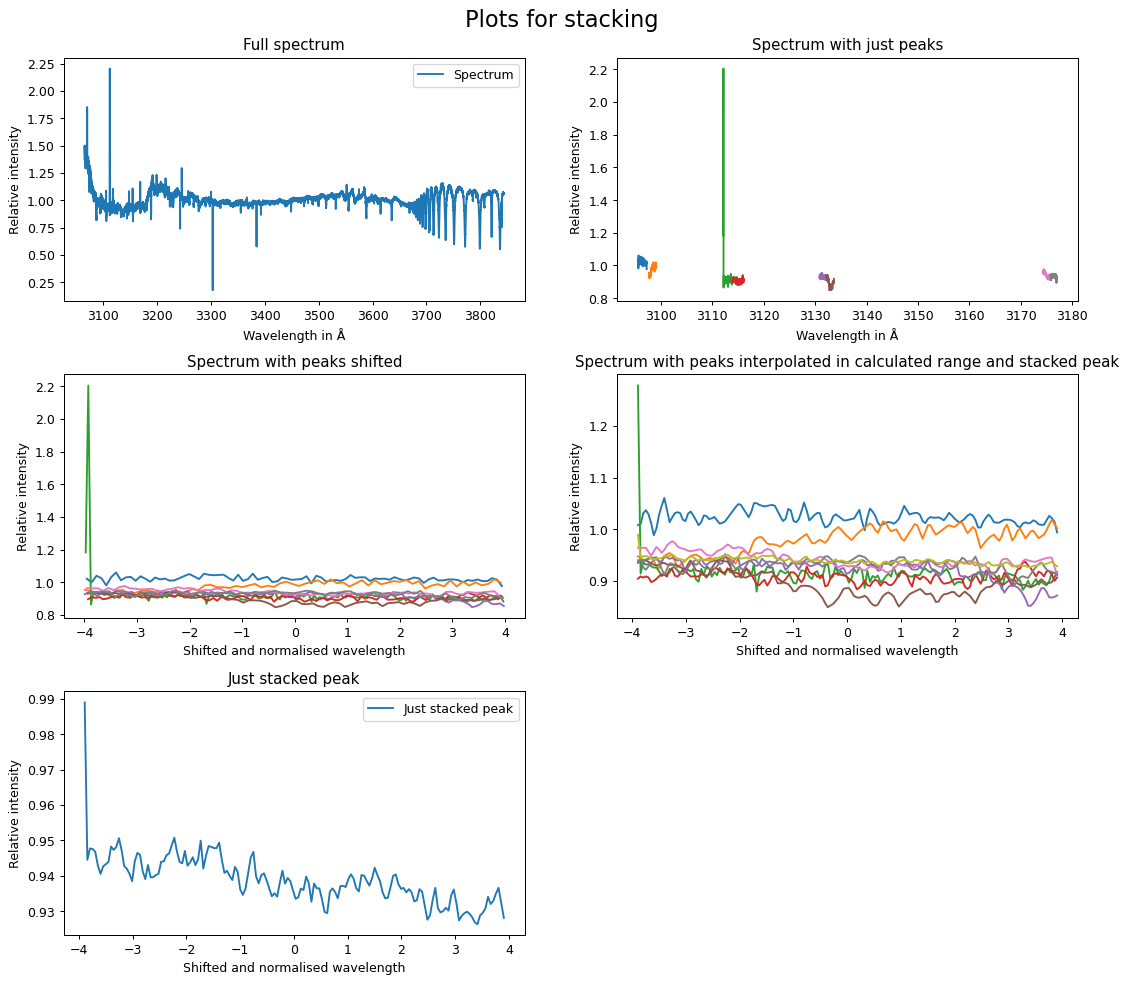

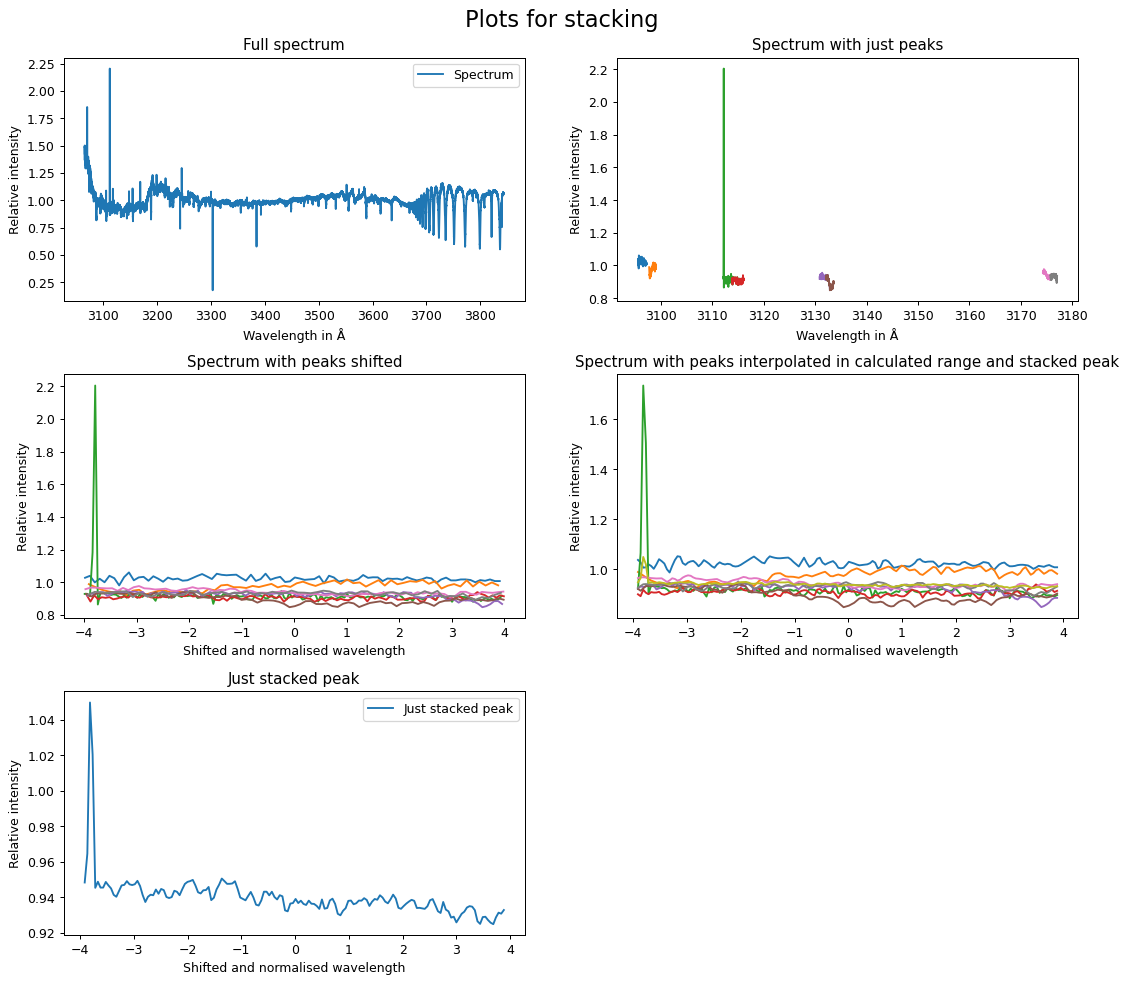

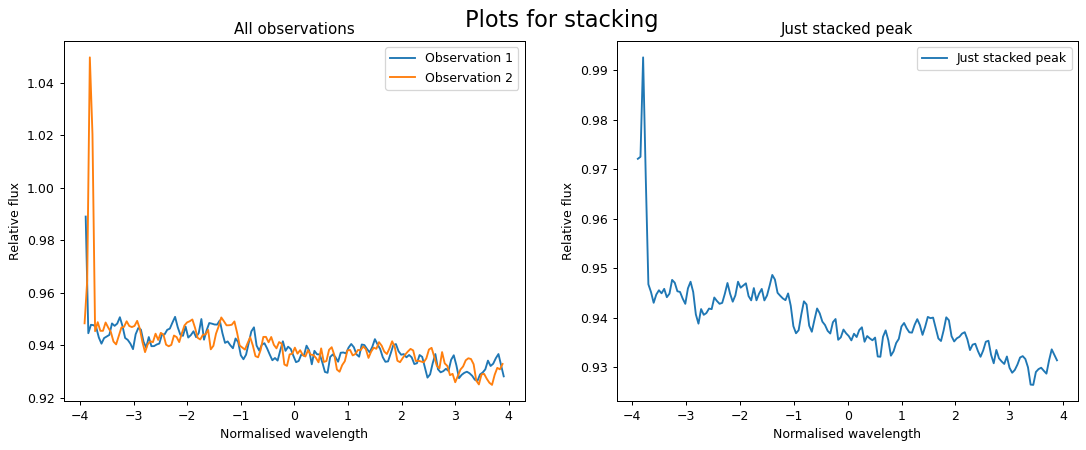

In [23]:
#saving cleaned up data, stacking and saving stacked data and image
#if on jupyter, just run this part

#print(datas[0].shape)
#print(np.logical_and(datas[:, 0] >= 4085, datas[:, 0] <= 4115).shape)

#totalStack = np.empty()
#stackRanges = np.zeros((len(datas)*len(datas[0]), 2))
#totalpoints = 0

"""
for it10 in range(len(datas)):
    for it11 in range(len(datas[it10])):
        totalpoints = totalpoints + datas[it10][it11][1].shape[0]
        
totalStack = np.zeros((totalpoints, 2))
"""
totalStack = np.empty(shape = clouds*obs, dtype = object)
#print(totalStack.shape)

for it8 in range(clouds):
    for it9 in range(obs):
        totalStack[it8*obs + it9] = widthNormLinStacker(datas[it8][it9][1], molParam)
        clupFile = 'E:\\college\\mitacs\\Cleaned\\' + starName + '\\' + starName.replace(' ','') + '_Observation' + str(it8*obs + it9 + 1) + '_' + datas[it8][it9][0].replace('/','_') +'.txt'
        if (not os.path.exists(clupFile)) or fEdit1 == 1:
            np.savetxt(clupFile, datas[it8][it9][1])
        
#print(totalStack.shape)
#print(stackRanges)
fileName = 'E:\\college\\mitacs\\FinalStacks\\' + starName + '\\' + starName.replace(' ','') + '_' + molName + '.txt'
imgFileName = 'E:\\college\\mitacs\\FinalStacks\\' + starName + '\\' + starName.replace(' ','') + '_' + molName + '.jpg'

if (not os.path.exists(imgFileName)) or fEdit2 == 1:
    imgSav = True
    imgAdd = imgFileName
else:
    imgSav = False
    imgAdd = ''

finalStacked = observationStacker(totalStack, 
                                  [['Normalised wavelength', 'No units'], ['Relative flux', 'No units']],
                                  saveJPG = imgSav,
                                  address = imgAdd)

if (not os.path.exists(fileName)) or fEdit2 == 1:
    np.savetxt(fileName, finalStacked)